# Predicting house prices: regression example

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.datasets import boston_housing

In [2]:
(train_data, train_targets), (test_data,test_targets) = boston_housing.load_data()

In [3]:
train_data.shape, test_data.shape

((404, 13), (102, 13))

## Normalizing the data

In [4]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

## Model

In [5]:
from tensorflow.keras import models
from tensorflow.keras import layers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

## K fold validation

K-fold cross-validation consists of splitting the available data into K partitions (typically K= 4 or 5), instantiating K identical models, and training each one on K-1 partitions while evaluating on the remaining partition. The validaiton score for the model used is then the average of the K validation scores obtained.

In [6]:
k = 4
num_val_samples = len(train_data)//k
num_epochs = 100
all_mae_histories=[]

for i in range(k):
    print("processing fold #",i)
    val_data = train_data[i * num_val_samples: (i+1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i+1) * num_val_samples]
    partial_train_data = np.concatenate(
        [
            train_data[:i*num_val_samples],
            train_data[(i+1)*num_val_samples:]
        ],
        axis=0
    )
    partial_train_targets = np.concatenate(
        [
            train_targets[:i*num_val_samples],
            train_targets[(i+1)*num_val_samples:]
        ],
        axis=0
    )
    
    model = build_model()
    history = model.fit(partial_train_data,
                        partial_train_targets,
                        validation_data=(val_data,val_targets),
                        epochs=num_epochs,
                        batch_size=1,
                        verbose=0
                       )
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [7]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)
]

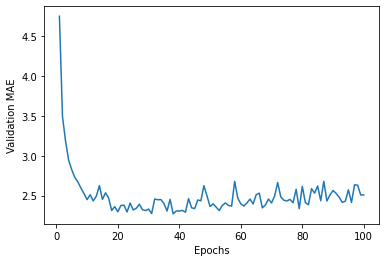

In [8]:
import matplotlib.pyplot as plt

plt.plot(range(1,len(average_mae_history)+1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [9]:
def smooth_curve(points, factor=0.95):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous*factor + point*(1-factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

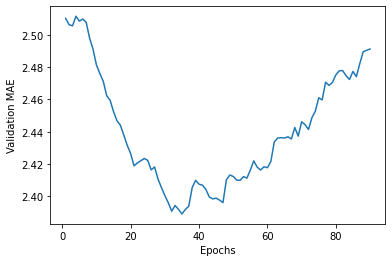

In [10]:
smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history)+1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [11]:
model = build_model()
model.fit(train_data, train_targets ,epochs=80, batch_size=16, verbose=0)
model.evaluate(test_data,test_targets)

4/4 [==============================] - 0s 3ms/step - loss: 15.9431 - mae: 2.6315


[15.943061828613281, 2.6315460205078125]